In [1]:
import torch
import torch.nn as nn
import nltk
from PIL import Image
from torch.autograd import Variable
from utils.build_vocab import Vocabulary
from model import  EncoderCNN, VRNN
from utils.data_loader import get_loader
from collections import Counter
import pickle
from sys import path
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence
import numpy as np
from numpy.random import random_sample
%matplotlib inline

In [2]:
class control_grad:
    def __init__(self, volatile):
        self.grad_mode_obj = torch.no_grad() if volatile else None
    def __enter__(self):
        if self.grad_mode_obj is not None:
            self.grad_mode_obj.__enter__()
    def __exit__(self, typ, value, traceback):
        if self.grad_mode_obj is not None:
            return self.grad_mode_obj.__exit__(typ, value, traceback)
    
def to_var(x, volatile=False):
    with control_grad(volatile):
        if torch.cuda.is_available():
            return Variable(x).cuda()
        return Variable(x)

In [3]:
with open('../data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])
rt_image = '../data/val_resized2014'
annotations = '../data/captions_val2014.json'
batch_size = 1
data_loader = get_loader(rt_image, annotations, vocab, transform, batch_size, False, 1)

../data/captions_val2014.json
loading annotations into memory...
0:00:00.732182
creating index...
index created!


In [4]:
checkpoint = '4-16000'
encoder = EncoderCNN(256)
encoder.eval()
decoder = VRNN(256, 512, len(vocab), 512, 1)
assert len(vocab) == decoder.det_x.out_features

In [7]:
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

In [8]:
encoder.load_state_dict(torch.load('models/encoder_pretrained.pkl'))
decoder.load_state_dict(torch.load('models/decoder-%s.pkl' % checkpoint))

In [9]:
for i, (images, captions, lengths, img_id, ann_id) in enumerate(data_loader):
    if i == 1:
        break
images_tensor = to_var(images, volatile=True)
captions = to_var(captions) # (1, 20(caption length))
images = [np.transpose(i.numpy(), (1,2,0)) for i in images]
features = encoder(images_tensor)

In [10]:
def decode_captions(captions, lengths, z_step=0):
    return [' '.join([vocab.idx2word[word_id.item()] for word_id in captions.data[i][1:lengths[i]-1-z_step]]) for i in range(captions.shape[0])]
print('\n'.join(decode_captions(captions, lengths)))

a balding man is holding a black microphone .


['a balding man is holding']
['a small elephant .']
['piece of pizza on']


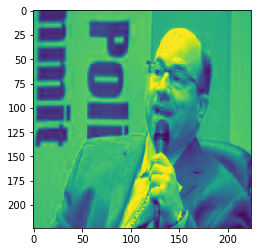

In [152]:
z_step = 5
plt.imshow(images[0][:,:,0])
ids = decoder.sample(features, captions, z_step=z_step)
print(decode_captions(captions[:,:z_step+1], lengths))
print(decode_captions(ids[0], lengths, z_step=z_step))
print(decode_captions(ids[1], lengths, z_step=z_step))